In [2]:
import re
import os
from datetime import datetime
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import random
random.seed(42)
from collections import Counter
import docx2txt

import nltk
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, recall_score, classification_report

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, LeakyReLU, TimeDistributed, Bidirectional, SimpleRNN
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import Nadam, Adam # adaptive moment estimation
from keras.losses import BinaryCrossentropy
import keras
from keras import backend as K
from sklearn.model_selection import train_test_split


In [2]:
df1 = pd.read_csv('articles1.csv')
df2 = pd.read_csv('articles2.csv')

In [3]:
# loading our error dictionaries
letters_and_errors_path = "letters_errors.csv"
special_chars_and_errors_path = "special_chars_errors.csv"

letters_errors = pd.read_csv(letters_and_errors_path, quoting=csv.QUOTE_NONE, encoding='utf-8')
special_chars_and_errors = pd.read_csv(special_chars_and_errors_path, quoting=csv.QUOTE_NONE, encoding='utf-8')

In [4]:
def sort_df_of_errors(df):
    """Sorting dataframe of errors according to its Count column, in descending order"""
    df = df.sort_values(by=["Count"], ascending=False)
    return df.reset_index(drop=True) # reseting the indices (after sorting rows, they have no meaning, so reseting the indices)

In [5]:
sorted_letters_errrors_df = sort_df_of_errors(letters_errors)
sorted_specialchars_errors_df = sort_df_of_errors(special_chars_and_errors)

In [6]:
def create_tuples_of_errors_and_amount_of_errors(df):
    """
    string looks like this: "correct_char => error_char"
    [(string, int), (string, int), (string, int) ...]
    """
    error_strings_and_count_tuples = []
    
    for _, row in df.iterrows():
        error_string = f'{row["Real"]} => {row["Error"]}'
        count = row["Count"]
        error_strings_and_count_tuples.append((error_string, count))
    
    return error_strings_and_count_tuples   

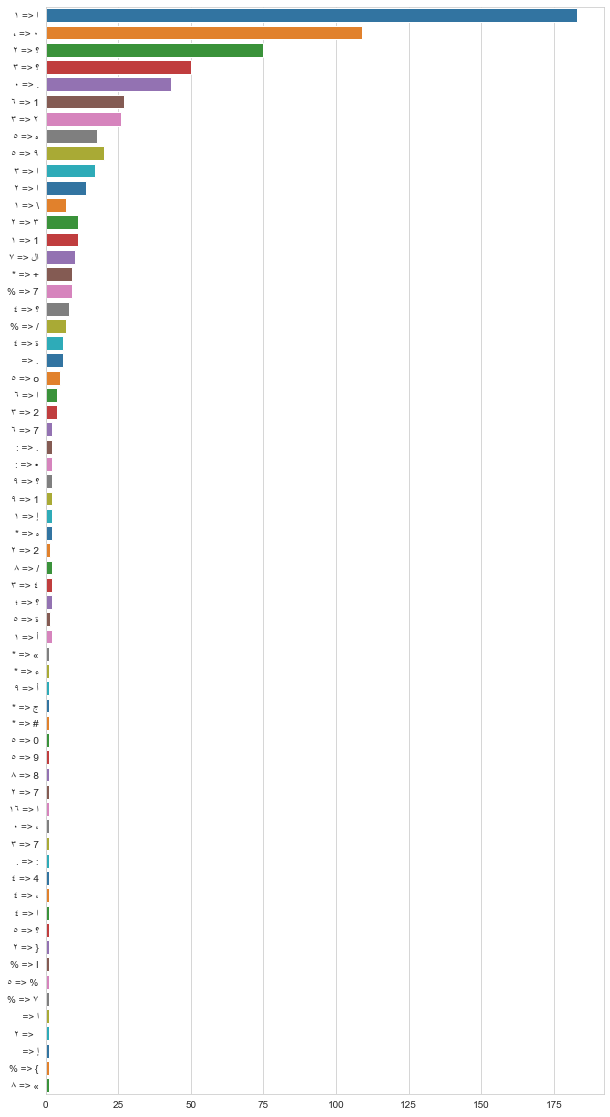

In [7]:
sns.set_style(style="whitegrid")

x_labels_letters = list(map(lambda kv: kv[1], create_tuples_of_errors_and_amount_of_errors(sorted_letters_errrors_df))) # numbers
y_labels_letters = list(map(lambda kv: kv[0], create_tuples_of_errors_and_amount_of_errors(sorted_letters_errrors_df))) # strings
x_labels_specialchars = list(map(lambda kv: kv[1], create_tuples_of_errors_and_amount_of_errors(sorted_specialchars_errors_df))) # numbers
y_labels_specialchars = list(map(lambda kv: kv[0], create_tuples_of_errors_and_amount_of_errors(sorted_specialchars_errors_df))) # strings
plt.figure(figsize=(10, 20))
sns.barplot(x=x_labels_specialchars, y=y_labels_specialchars, ci=None, palette='tab10');

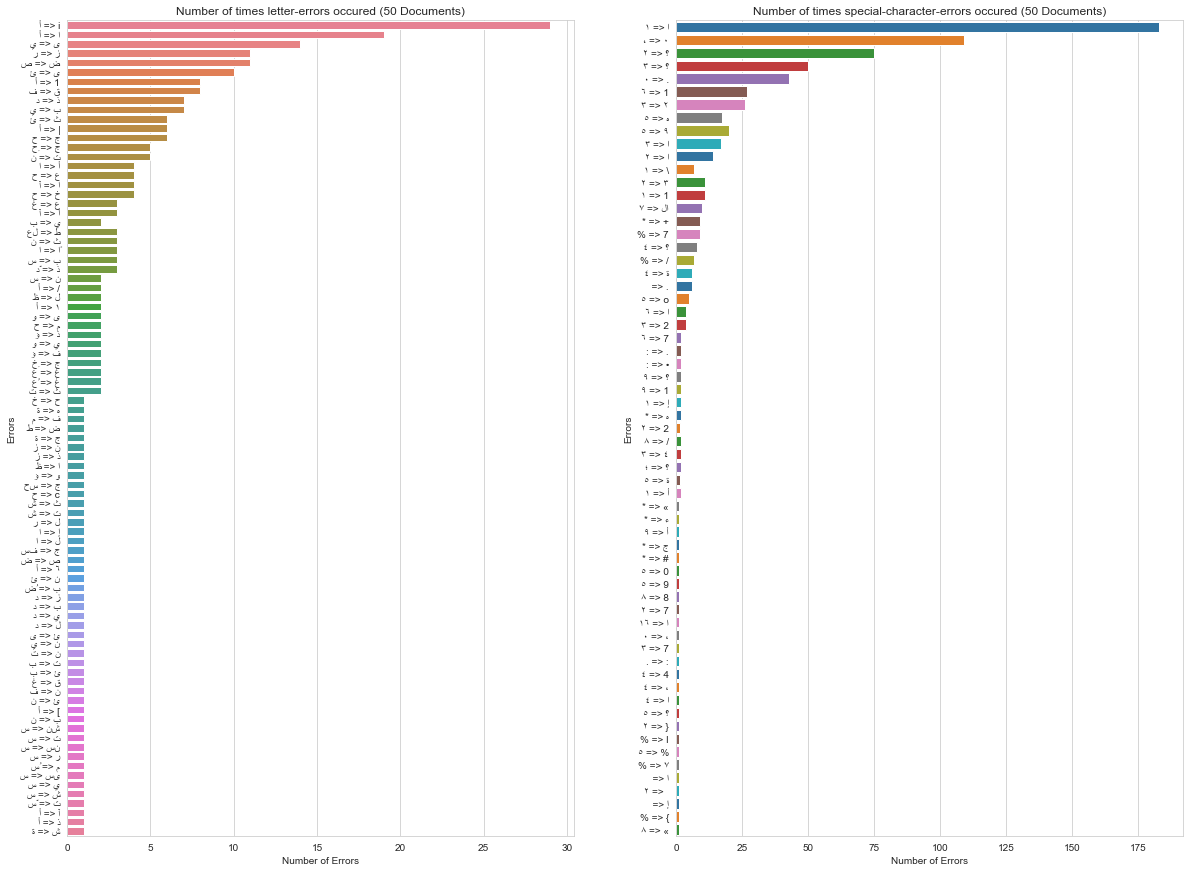

In [8]:
sns.set_style(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(20,15))
x_labels_letters = list(map(lambda kv: kv[1], create_tuples_of_errors_and_amount_of_errors(sorted_letters_errrors_df))) # numbers
y_labels_letters = list(map(lambda kv: kv[0], create_tuples_of_errors_and_amount_of_errors(sorted_letters_errrors_df))) # strings
x_labels_specialchars = list(map(lambda kv: kv[1], create_tuples_of_errors_and_amount_of_errors(sorted_specialchars_errors_df))) # numbers
y_labels_specialchars = list(map(lambda kv: kv[0], create_tuples_of_errors_and_amount_of_errors(sorted_specialchars_errors_df))) # strings

sns.barplot(x=x_labels_letters, y=y_labels_letters, ax=axes[0], ci=None, palette='husl');
sns.barplot(x=x_labels_specialchars, y=y_labels_specialchars, ax=axes[1], ci=None, palette='tab10');

axes[0].set_title("Number of times letter-errors occured (50 Documents)");
axes[0].set_xlabel("Number of Errors");
axes[0].set_ylabel("Errors");

axes[1].set_title("Number of times special-character-errors occured (50 Documents)");
axes[1].set_xlabel("Number of Errors");
axes[1].set_ylabel("Errors");

In [9]:
def create_error_dict_and_reaL_list(errors_df):
    """
    Creates list of true characters, and also creates python dictionary of real and error chars
    """

    lst_of_real = []
    dict_of_errors = {}
    for i, row in errors_df.iterrows():
        lst_of_real.append((i,row["Real"]))
        dict_of_errors[i] = (str(row["Real"]), str(row["Error"]))
        
    return lst_of_real, dict_of_errors


In [10]:
# defining parameters for the deliberate-damage function
damage_ratio=0.8
max_sent_len = 50
max_sentences = 200

In [12]:
def deliberate_damage(text, letters_errors, specialchars_errors):
    
    lst_reg_real_token, real_error_dict_reg = create_error_dict_and_reaL_list(letters_errors)
    lst_special_real_token, real_error_dict_special = create_error_dict_and_reaL_list(specialchars_errors)
    all_words_len = len(nltk.word_tokenize(text))
    sentences = text.split("\n")
    damage_words_sentences_indexes = np.zeros((len(sentences), max_sent_len))
    
    # total amount of damage for special and regular token
    total_damage_reg_token = int(damage_ratio * all_words_len * 0.8)
    total_damage_special_token = int(damage_ratio * all_words_len * 0.2)
    
    
    # create distribution for each token and number of time to damage
    reg_dict = Counter(lst_reg_real_token[int(random.betavariate(1.3, 5)*len(lst_reg_real_token))] for _ in range(total_damage_reg_token))
    special_dict =Counter(lst_special_real_token[int(random.betavariate(0.1, 5)*len(lst_special_real_token))] for _ in range(total_damage_special_token))
    
    for i, token_real_tup in enumerate(reg_dict):
        token_real = token_real_tup[1] # token_real_tup ('7','ف') example
        index_of_token = token_real_tup[0]
        just_the_tuple = real_error_dict_reg[index_of_token]#just_tuple contain ('real','error')
        for j in range(reg_dict[token_real_tup]):
            # take random sentence
            sent_idx = random.randint(0, len(sentences) -1)
            sent = sentences[sent_idx]
            sent = " ".join(sent.split())
            words = sent.split()

            # Check in which words the charcter appear in
            word_char_occur = []
            for j, word in enumerate(words):
                if token_real in word and j < max_sent_len:
                    word_char_occur.append(j)

                if j >= max_sent_len:
                    break
                
            # if there is no appearnce, concatanate the sentence and continue the next loop
            if word_char_occur == []:
                sent = ' '.join(words)
                sentences[sent_idx] = sent
                continue
            
            # if there are appearances, take random word, 
            word_idx = random.randint(0, len(word_char_occur) -1)
            word_idx = word_char_occur[word_idx]
            if damage_words_sentences_indexes[sent_idx][word_idx] == 0:
                word = words[word_idx]
                if len(token_real) == 2:
                    just_the_tuple = real_error_dict_reg[index_of_token]
                    # print("char got replaced")
                    new_word = word.replace(token_real, just_the_tuple[1])#(real char,error char)
                    words[word_idx] = new_word
                    damage_words_sentences_indexes[sent_idx][word_idx] = 1
                    # print("change to error")
                else:
                    first_occur = word.find(token_real)
                    word = list(word)
                    just_the_tuple = real_error_dict_reg[index_of_token]# new
                    # print("char got replaced")
                    word[first_occur] = just_the_tuple[1]
                    word = ''.join(word)
                    words[word_idx] = word
                    damage_words_sentences_indexes[sent_idx][word_idx] = 1

            sent = " ".join(words)
            sentences[sent_idx] = sent
            
    for i, token_special_tup in enumerate(special_dict):
        token_special = token_special_tup[1]
        index_of_token = token_special_tup[0]
        for j in range(special_dict[token_special]):
            
            # take random sentence
            sent_idx = random.randint(0, len(sentences) -1)
            sent = sentences[sent_idx]
            sent = " ".join(sent.split())
            words = sent.split()
            
            # Check in which words the charcter appear in
            word_char_occur = []
            for j, word in enumerate(words):
                if token_special in word and j < max_sent_len:
                    word_char_occur.append(j)
                
                if j >= max_sent_len:
                    break
                
            # if there is no appearnce, concatanate the sentence and continue the next loop
            if word_char_occur == []:
                sent = ' '.join(words)
                sentences[sent_idx] = sent
                continue
            
            # if there are appearances, take random word, 
            word_idx = random.randint(0, len(word_char_occur) -1)
            word_idx = word_char_occur[word_idx]
            if damage_words_sentences_indexes[sent_idx][word_idx] == 0:
                word = words[word_idx]
                first_occur = word.find(token_special)
                word = list(word)
                just_the_special_tuple = real_error_dict_special[index_of_token]
                word[first_occur] = just_the_special_tuple[1] #replace it with error
                word = ''.join(word)
                words[word_idx] = word
                damage_words_sentences_indexes[sent_idx][word_idx] = 1

            sent = " ".join(words)
            sentences[sent_idx] = sent

    text = '\n'.join(sentences)
    return text, damage_words_sentences_indexes


In [13]:
def create_damaged_df_and_labels(df1, df2, damage_df, damage_df_special):
    
    df_damage_lst = []
    
    for i, row in tqdm(df1.iterrows(), desc="Damaging 111,728 Documents"):
        
        damaged_text, damaged_words_sen = deliberate_damage(row["text"], damage_df, damage_df_special) # returning damaged text and the ground_truth matrix.
        df_damage_lst.append({
            "law_id": f'common_{i}',
            "damaged_text": damaged_text,
            "damaged_words_sen": damaged_words_sen,
        })
    
    for i, row in tqdm(df2.iterrows(), desc="Damaging 5870 Documents"):
        
        damaged_text, damaged_words_sen = deliberate_damage(row["text"], damage_df, damage_df_special)
        df_damage_lst.append({
            "law_id": f'aljazeera_{i}',
            "damaged_text": damaged_text,
            "damaged_words_sen": damaged_words_sen,
        })
        
    col_names = ["law_id", "damaged_text", "damaged_words_sen"] # defining the columns for our new dataframe
    return pd.DataFrame(df_damage_lst, columns=col_names)

damaged_df = create_damaged_df_and_labels(df1, df2, sorted_letters_errrors_df, sorted_specialchars_errors_df)
random.seed(42)

Damaging 111,728 Documents: 108789it [1:00:48, 29.82it/s]
Damaging 5870 Documents: 5870it [01:46, 54.97it/s]


In [11]:
# damaged_df.to_pickle('serialized/damaged_df.pickle')
damaged_df = pd.read_pickle('serialized/damaged_df.pickle')

In [26]:
damaged_df['damaged_words_sen'][0]

array([[1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
        0., 1.]])

In [14]:
# damaged_df['damaged_words_sen'][0].shape

(1, 50)

In [15]:
# percentage of damaged words
print(f'number of rows in damaged df: {damaged_df.shape}')
m = damaged_df['damaged_words_sen'][0]
print(m.shape)
print(np.count_nonzero(m==1))
print(np.count_nonzero(m==0))

one_counter = 0
zero_counter = 0
for _, row in damaged_df.iterrows():
    one_counter += np.count_nonzero(row['damaged_words_sen']==1)
    zero_counter += np.count_nonzero(row['damaged_words_sen']==0)

# print(one_counter / (zero_counter+one_counter))

number of rows in damaged df: (114659, 3)
(1, 50)
41
9


In [16]:
print(one_counter / (zero_counter+one_counter))

0.3013358363910459


In [23]:
def save_text_damaged_in_file(text, path):
    
    """
    Saves a damaged text file in path
    Args:
        text (String): text to be saved.
        path (String): where to save the text file.
    """
    
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        f.write(text)

def save_ground_truth_in_file(np_matrix, path):
    os.makedirs(os.path.dirname(path), exist_ok=True) # exists_ok: if it's already created, don't create.
    np.save(path, np_matrix) # save method (from numpy module)

def save_damaged_text_from_df(df):
    """Creates 2 folders; one for damaged texts and one for ground truth
       matrix for each damaged text.

    Args:
        df (dataframe): contains damaged texts and its ground truth matrix
    """
    base_file_path = "./damaged_texts"
    base_file_path_gt = "./ground_truth"
    for i, row in df.iterrows():
        law_id = row["law_id"]
        ground_truth = row["damaged_words_sen"]
        law_damaged_text = row["damaged_text"][1:]
        
        file_path = f'{base_file_path}/{law_id}.txt'
        
        gt_file_path = f'{base_file_path_gt}/{law_id}.npy' # where to save ground truth matrix
        
        save_text_damaged_in_file(law_damaged_text, file_path)
        
        save_ground_truth_in_file(ground_truth, gt_file_path)
        

In [24]:
# saving files
# save_damaged_text_from_df(damaged_df)

Reading files from the disk to build our final damage dataframe

In [13]:
# # creating data frame
# directory = "./Damaged/"
# df_damage_lst = []
# for filename in tqdm(os.listdir(directory), desc="Reading Damaged Text Files"):
#     file = open(directory + filename, "r", encoding="utf-8")
#     damaged_text = file.read()
#     filename = filename[:-4] # excluding ".txt"
#     df_damage_lst.append({
#         "law_id": filename,
#         "damaged_text": damaged_text
#     })
# col_names = ["law_id", "damaged_text"]
# damaged_df_v1 = pd.DataFrame(df_damage_lst, columns=col_names)

# print('Finished reading damaged text files')


Reading Damaged Text Files: 100%|██████████| 114659/114659 [1:03:44<00:00, 29.98it/s]


Finished reading damaged text files


In [14]:
# directory = "./gt/"
# df_damage_lst = []
# for i, filename in tqdm(enumerate(os.listdir(directory)), desc="Reading Ground Truth Files (npy files)"):
#     mat = np.load(directory + filename)
#     mat = mat[1:] # exclude first row
#     filename = filename[:-4]
#     df_damage_lst.append({
#         "law_id": filename,
#         "damaged_text": damaged_df_v1["damaged_text"][i], # using the damaged df
#         "damaged_words_sen": mat,
#     })

# print('Finished reading npy files')

# col_names = ["law_id", "damaged_text", "damaged_words_sen"]
# damaged_df = pd.DataFrame(df_damage_lst, columns=col_names) # the final result from the previous 2 cells


Reading Ground Truth Files (npy files): 114659it [58:36, 32.61it/s]


Finished reading npy files


In [17]:
damaged_df = shuffle(damaged_df)

size = 114659


In [38]:
damaged_df2 = damaged_df[:114659//8]

In [39]:
# half_damaged_df['damaged_words_sen'][101661].shape
len(damaged_df2)

14332

In [40]:
X_train = damaged_df2["damaged_text"][4300:] # from file 1493 until 4976 there is 3483 files in total (70% of the dataset)
y_train = damaged_df2["damaged_words_sen"][4300:]

X_test, X_validation, y_test, y_validation = train_test_split(damaged_df2["damaged_text"][:4300], damaged_df2["damaged_words_sen"][:4300], test_size=0.66, random_state=24)


In [16]:
df1 = pd.read_csv('articles1.csv')
df2 = pd.read_csv('articles2.csv')

print(len(df1))
print(len(df2))
print('total number of documents: ', len(df1)+len(df2))

108789
5870
total number of documents:  114659


In [17]:
train_text1 = ' '.join(df1['text'][34398:])
train_text2 = ' '.join(df2['text'])
train_text = ' '.join([train_text1, train_text2])

In [18]:
def generate_tokenizer(train_txt):
    
    tokenizer_ = Tokenizer(filters='\t\n', oov_token='unk')
    tokenizer_.fit_on_texts([train_txt])
    vocab_size = len(tokenizer_.word_index) + 1 # tokenizer_.word_index returns dictionary of all words
    return tokenizer_, vocab_size

tokenizer, vocab_size = generate_tokenizer(train_text)

In [22]:
sentence_length = 50
batch_size = 200
epochs = 25

In [45]:
def create_X_set(lines, tokenizer): # lines is a list of sentences.
    """
    transform @lines to sequences given by @tokenizer.
    Args:
        lines (list(String)): list of lines composing a text file.
        tokenizer (keras.Tokenizer): a keras tokenizer trained on text.
    """
    # batch size is how many lines in this matrix (200 for all)
    # matrix of zeros (50*200) (before this we had contraint only on number of cols), here all the matrices of the same shape.
    lines_tokens = np.zeros((batch_size, sentence_length))
    
    for i, line in enumerate(lines):
        # taking only the first @batch_size lines
        if i < batch_size:
            line_seq = tokenizer.texts_to_sequences([line]) # creating sequence for this text (list of numerical lists)
            line_seq = pad_sequences(line_seq, maxlen=sentence_length, padding='post') # padding with zeros after the sentence is finished (until we reach 200 which is sentence_length)
            lines_tokens[i] = line_seq[0] # [0] because the sequences is inside a list of 1 item (index = 0)
        # else:
            # break
    return np.array([lines_tokens])

def create_y_set(damage_matrix):
    damaged_mat = np.zeros((batch_size, sentence_length))
    
    # if np.ndim(damage_matrix) != 0:
    for i, sen_damage_mat in enumerate(damage_matrix):
        # taking only the first @batch_size matrices
        if i < batch_size:
            # pad each sequence with 0 to reach @sentence_length
            sen_damage_mat = np.array(sen_damage_mat)
            curr_damage = pad_sequences([sen_damage_mat], maxlen=sentence_length, padding='post')
            damaged_mat[i] = curr_damage
        # else:
            # break
    
    return np.array([damaged_mat])

def create_X_and_y_set(text_lines, tokenizer, label):
    """creating a constant shape from texts (array of sequences) and damage matrix

    Args:
        text_lines (list(string)): list of sentences
        tokenizer (Tokenizer): generated tokenizer of all texts
        label (np.array): ground truth matrix for this damaged text
    """
    X = create_X_set(text_lines, tokenizer)
    y = create_y_set(label)
    return X, y

In [46]:
def create_models_sets(texts, labels, tokenizer): # we use the ground thuth matrices as labels
    """
    Creating train sequences and labels in a constant shape.
    Args:
        texts (list(String)): all the texts files.
        labels (list(numpy.array)): damaged matrices labels for all the documents.
        tokenizer (keras.Tokenizer): a keras tokenizer trained on text.
    """
    
    # creating x and y from the first text seperately. why? to be able to make vertical stacking (np.vstack) in the loop
    texts_and_labels = list(zip(texts[1:], labels[1:])) # mapping each text with its matrix -> in a list
    X, y = create_X_and_y_set(texts[0].split("\n"), tokenizer, labels[0]) # send list of sentences and gt matrix
    
    for text, label in tqdm(texts_and_labels, desc="Creating train/test sets"):
        curr_X, curr_y = create_X_and_y_set(text.split("\n"), tokenizer, label)
        X = np.vstack((X, curr_X))
        y = np.vstack((y, curr_y))
    return X, y # X is "stack" of arrays one over the other (sequecnces of 200*50 matrices)

In [47]:
# 12 vars in total: 6 before reshape, 6 after reshape
X_train_v2, y_train_v2 = create_models_sets(X_train.values, y_train.values, tokenizer)

Creating train/test sets: 100%|██████████| 10031/10031 [39:51<00:00,  4.19it/s]


In [48]:
X_test_v2, y_test_v2 = create_models_sets(X_test.values, y_train.values, tokenizer)

Creating train/test sets: 100%|██████████| 1461/1461 [00:46<00:00, 31.41it/s]


In [49]:
X_validation_v2, y_validation_v2 = create_models_sets(X_validation.values, y_validation.values, tokenizer)

Creating train/test sets: 100%|██████████| 2837/2837 [03:22<00:00, 13.98it/s]


In [50]:
X_train_reshaped = X_train_v2.reshape((-1, sentence_length))
y_train_reshaped = y_train_v2.reshape((-1, sentence_length))

X_validation_reshaped = X_validation_v2.reshape((-1, sentence_length))
y_validation_reshaped = y_validation_v2.reshape((-1, sentence_length))

X_test_reshaped = X_test_v2.reshape((-1, sentence_length))
y_test_reshaped = y_test_v2.reshape((-1, sentence_length))

In [55]:
# import pickle
# to_pickle = [X_train_reshaped, y_train_reshaped, X_validation_reshaped, y_validation_reshaped, X_test_reshaped, y_test_reshaped]
# pickle_out = open('serialized/models_sets_eighth_of_damage_df/damagedf2_models_sets.pickle', 'wb')
# pickle.dump(to_pickle, pickle_out)
# pickle_out.close()

In [56]:
# pickle_in = open('serialized/models_sets_eighth_of_damage_df/damagedf2_models_sets.pickle', 'rb')
# six_vars_of_models_sets = pickle.load(pickle_in)

In [3]:
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(model.predict(X_val))
        mat = confusion_matrix(np.squeeze(y_val).reshape(-1), np.squeeze(y_predict.round()).reshape(-1))
        perc=(mat[1][1])/(mat[1][1]+mat[0][1] + 0.00001)
        reco=(mat[1][1])/(mat[1][1]+mat[1][0] + 0.00001)
        print(f"percision_bar = {float(perc)}")
        print(f"recall_bar = {float(reco)}")
        print(f"True positive = {mat[1][1]}")
        print(f"True negative = {mat[0][0]}")
        print(f"False positive = {mat[0][1]}")
        print(f"False negative = {mat[1][0]}")

    def get_data(self):
        return self._data

In [4]:
checkpoint = ModelCheckpoint("./models/try1"+"_weights.{epoch:02d}-{val_loss:.5f}.hdf5",save_best_only=False,monitor='val_loss')
earlystopping = EarlyStopping(monitor='val_loss' ,patience=5, restore_best_weights=False, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_delta=0.001, mode='min', min_lr=1e-6)
metrics_bar = Metrics()

callbacks = [earlystopping, reduce_lr, checkpoint, metrics_bar]

In [4]:
# calculates the loss function and returns it.
# takes 2 weights (3 and 1) and returns loss function (takes true y and predict y)
def weighted_binary_crossentropy_v1(w1, w2):
    def loss(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
        y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
        # y_true * log(y_pred) * w1 + (1-y_true) * log (1 - y_pred) * w2 then multiply by -1
        logloss = -(y_true * K.log(y_pred) * w1 + (1 - y_true) * K.log(1 - y_pred) * w2 )
        return K.mean(logloss, axis=-1)

    return loss

In [20]:
sentence_length = 50
batch_size = 200

hidden_size = 100
units_lstm = 125

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=hidden_size, input_length=sentence_length, trainable=False))
model.add(LSTM(units=units_lstm, return_sequences=True))
model.add(LSTM(units=units_lstm, return_sequences=True))
model.add(LSTM(units=units_lstm, return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(1, activation="sigmoid")))
print(model.summary())


In [88]:
# defining an optimizer
opt = Nadam(learning_rate=0.01)

In [89]:
model.compile(opt, loss=weighted_binary_crossentropy_v1(3, 1), metrics=["accuracy"])

In [93]:
# reshaping the lables
shaped_y_train = np.expand_dims(y_train_reshaped, axis=2)
shaped_y_validation = np.expand_dims(y_validation_reshaped, axis=2)

In [95]:
# training the model
model.fit(x=X_train_reshaped, y=shaped_y_train, validation_data=(X_validation_reshaped, shaped_y_validation), batch_size=128, epochs=1, callbacks=callbacks)

Train on 2006400 samples, validate on 567600 samples
Epoch 1/1
2006400/2006400 [==============================] - 20701s 10ms/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.0055 - val_accuracy: 0.9984
percision_bar = 0.7581450950553626
recall_bar = 0.9635001737718629
True positive = 127473
True negative = 28207033
False positive = 40665
False negative = 4829


Measurements:
- Accuracy: 90%
- Precision: 76%
- Recall: 96%